# CSE 258, Fall 2019: Homework 3

Student ID: A53308934 <br>
Student Name: Deng Zhang

## Tasks - Read Prediction

In [39]:
import gzip
from collections import defaultdict
import random
from random import randint
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import numpy as np
from sklearn.metrics import mean_squared_error

In [40]:
def readCSV(path):
  f = gzip.open(path, 'rt')
  for l in f:
    yield l.strip().split(',')

def readCSVLine(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

dataset = []
first = True
for line in readCSV("train_Interactions.csv.gz"):
    # The first line is the header
    if first:
        header = line
        first = False
    else:
        d = dict(zip(header, line))
        # Convert strings to integers for some fields:
        d['rating'] = int(d['rating'])
        dataset.append(d)


In [41]:
print(dataset[0], type(dataset[0]['rating']))

{'userID': 'u79354815', 'bookID': 'b14275065', 'rating': 4} <class 'int'>


In [42]:
training = dataset[:190000]
validation = dataset[190000:]

Although we have built a validation set, it only consists of positive samples. For this task we also need examples of user/item pairs that weren’t read. For each entry (user,book) in the validation set, sample a negative entry by randomly choosing a book that user hasn’t read .1 Evaluate the performance (accuracy) of the baseline model on the validation set you have built (1 mark).

### Question 1

In [78]:
# Store all the book that a user read in its dictionary

userBook = defaultdict(set)  # store the user-book pair
bookUser = defaultdict(set)  # store the book-user pair
userList = set()
bookList = set()
bookRating = defaultdict(int)
userRating = defaultdict(int)

for entry in dataset:
    userID, bookID,rating = entry['userID'], entry['bookID'], entry['rating']
    userBook[userID].add(bookID)
    bookUser[bookID].add(userID)
    bookRating[bookID] += rating
    userRating[userID] += rating
    userList.add(userID)
    bookList.add(bookID)
    
for b,v in bookRating.items():
    bookRating[b] /= lenBooks[b]
    
for u,v in userRating.items():
    userRating[u] /= lenUsers[u]

# sample a negative entry by randomly choosing a book that user hasn’t read 

notRead = []
repeat = True
for entry in validation:
    userID = entry['userID']
    bookID = entry['bookID']
    booksNotRead = bookList-userBook[userID]
    bookNotRead = random.choice(list(booksNotRead))
    notRead.append((userID, bookNotRead))

len(notRead), len(validation)

# Construct new validation set

new_userBook = []
new_read = []
for entry in validation:
    new_userBook.append((entry['userID'], entry['bookID']))
    new_read.append(1)

new_userBook += notRead
new_read += len(notRead) * [0]

print(bookRating['b14275065'], userRating['u79354815'])

3.8055555555555554 3.727272727272727


In [44]:
# Would-read baseline: just rank which books are popular and which are not, 
# and return '1' if a book is among the top-ranked

bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSVLine("train_Interactions.csv.gz"):
    bookCount[book] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()
#print(mostPopular[0])

def diffThreshold(precentile):
    return1 = set()
    count = 0
    num = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        num += 1
        if count > totalRead * precentile / 100: 
            break
    return return1

def predict_read(u, b, return1):
    if b in return1:
        return 1
    else:
        return 0

def evaluate_read(read_predict, prec, X, y):
    accuracy = 0
    return1 = diffThreshold(prec)
    for (u,b), r in zip(X, y):
        read = int(read_predict(u, b, return1))
        accuracy += int(read == r)
    return accuracy / len(X)


accuracy = evaluate_read(predict_read, 50, new_userBook, new_read)
print("The Accuracy is: %f" % accuracy)

The Accuracy is: 0.648150


### Question 2

In [45]:
# Count accuracy at different threshold

bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSVLine("train_Interactions.csv.gz"):
    bookCount[book] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

accuThreshold = []
for prec in range(0, 101, 1):
    accuracy = evaluate_read(predict_read, prec, new_userBook, new_read)
    accuThreshold.append(accuracy)

for pre in range(50, 70, 1):
    accuracy = evaluate_read(predict_read, pre, new_userBook, new_read)
    print(pre, str(accuracy))
#accuracy = evaluate_read(read_predict, 60 , new_userBook, new_read)
#print("The Accuracy at 65 is: %f" % accuracy)
# 65 -> 0.66275

50 0.64815
51 0.64765
52 0.6497
53 0.6509
54 0.65145
55 0.65295
56 0.65345
57 0.6537
58 0.6541
59 0.6532
60 0.6539
61 0.6539
62 0.65375
63 0.6535
64 0.65355
65 0.65475
66 0.6539
67 0.653
68 0.65305
69 0.6531


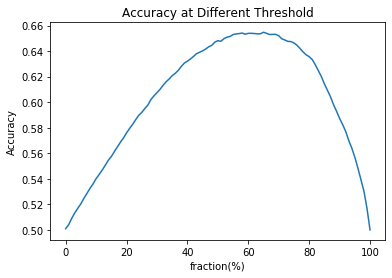

In [46]:
plt.plot(range(0, 101, 1), accuThreshold)
plt.title("Accuracy at Different Threshold")
plt.xlabel("fraction(%)")
plt.ylabel("Accuracy")
plt.show()

### Question 3

In [48]:
# get the max Jaccard Similiary of all the books that user has read with 

def get_Jaccard(u, b):
    max_Jaccard = 0
    for book in userBook[u]:
        if b in bookUser:  # if this book has not been read by user in training set
            if book == b: continue
            intersection = len(list(bookUser[book].intersection(bookUser[b])))
            union = (len(bookUser[book]) + len(bookUser[b])) - intersection
            max_Jaccard = max(max_Jaccard, intersection / union)
    return max_Jaccard

def predict_Jaccard(u, b, thershold):
    jaccardValue = get_Jaccard(u, b)
    if jaccardValue > thershold/1000:
        return 1
    else:
        return 0

# res_Jacc = []
# def predict_Jaccard(u, b, thershold):
#     jaccardValue = get_Jaccard(u, b)
#     res = 0
#     if jaccardValue > thershold/1000:
#         res = 1
#     else:
#         res = 0
#     res_Jacc.append(zip(u, b, res))
#     return res
    
def evaluate_Jaccard(thershold, X, y):
    accuracy = 0
    for (u,b), r in zip(X, y):
        read = int(predict_Jaccard(u, b, thershold))
        accuracy += int(read == r)
    return accuracy / len(X)

# accuJaccard = []
# for prec in range(0, 21, 1):
#     accuracy = evaluate_Jaccard(prec, new_userBook, new_read)
#     accuJaccard.append(accuracy)

# plt.plot(range(0, 101, 1), accuJaccard)
# plt.title("Jaccard Similarity at Different Threshold")
# plt.xlabel("Threshold(%)")
# plt.ylabel("Jaccard Similarity")
# plt.show()

In [25]:
for pre in range(0, 21, 1):
    print (pre, accuJaccard[pre])
print("Jaccard Similarity at 0.012 is: %f" % accuracy)

0 0.59115
1 0.59115
2 0.59115
3 0.5922
4 0.5947
5 0.59795
6 0.6041
7 0.6101
8 0.61685
9 0.6191
10 0.62195
11 0.6245
12 0.6228
13 0.62025
14 0.61605
15 0.6096
16 0.60375
17 0.59655
18 0.58915
19 0.5804
20 0.5723
Jaccard Similarity at 0.012 is: 0.572300


### Question 4

In [ ]:
userAll = []
bookAll = []


for b in book:
    if b in userBook[u]:
        ubList.append(1)
    else:
        ubList.append(0)

In [88]:
# Build a module which combines Jaccard and Popularity


# for i in range(20, 101, 1):
maxAccu = 0
popThe = 0
JacThe = 0
# for i in range(56, 68, 1):
#     for j in range(6, 15, 1):
#         accuracy = evaluate_combine(new_userBook, new_read, i, j)
#         if maxAccu < accuracy:
#             maxAccu = accuracy
#             popThe = i
#             JacThe = j

# accuracy = evaluate_combine(new_userBook, new_read, 65, 8)
# print(str(i) + '\t' + str(accuracy))

## Or:  read-38, Jaccard-23 -> 0.6563
## And: read-66, Jaccard-7  -> 0.6728
## 65 8 0.6735
## 66 8 0.67395
## 67 8 0.6744

def evaluate_combine(X, y, reThe, JaThe, JaThe2, reThe2):
    accuracy = 0
    return1 = diffThreshold(reThe)
    return2 = diffThreshold(reThe2)
    for (u,b), r in zip(X, y):
        pred_jac = int(predict_Jaccard(u, b, JaThe))
        pred_pop = int(predict_read(u, b, return1))
        if pred_jac == pred_pop:
            read = pred_jac
        else:
            read = int(predict_Jaccard(u, b, JaThe2)) or predict_read(u, b, return2)
#         read = pred_jac and pred_pop
        accuracy += int(read == r)
    return accuracy / len(X)

# 38: 67.61
# maxAcc = 0
# for i in range(56, 68, 1):
#     for j in range(6, 15, 1):
#         for k in range(30, 45, 1):
#             accuracy = evaluate_combine(new_userBook, new_read, i, j, k)
#             if (accuracy > maxAcc):
#                 myi, myj, myk = i, j, k
#             print(i, j, k, accuracy)

# print(myi, myj, myk, maxAcc)          

val = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.15]
for i in range(65, 100, 5):
    accuracy = evaluate_combine(new_userBook, new_read, 65, 8, 40, i)
    print(i, accuracy)

65 0.794
70 0.794
75 0.794
80 0.794


KeyboardInterrupt: 

### Question 5

In [62]:
# Make prediction on pairs_Read.txt

return1 = diffThreshold(66)

def predict(user, book):
    if not book in bookList:
        return 0
    else:
        pred_jac = int(predict_Jaccard(u, b, 8))
        pred_pop = int(predict_read(u, b, return1))
        if pred_jac == pred_pop:
            return pred_jac
        else:
            return int(predict_Jaccard(u, b, 40)) or bookRating[book] >= 4
            
       #return int(predict_Jaccard(u, b, 7)) and int(predict_read(u, b, return1))

predictions = open("predictions_newRead_1115.txt", 'w')

for l in open("pairs_Read.txt"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,b = l.strip().split('-')
    read = predict(u, b)
    if read == 1:
        predictions.write(u + '-' + b + ",1\n")
    else:
        predictions.write(u + '-' + b + ",0\n")

In [0]:
# Username: amazingme

### Question 9:

find the predictor of the form rating(user, item)

In [14]:
alpha = sum(int(d['rating']) for d in training) / len(training)
alpha

3.897121052631579

some basic functions

In [59]:
# prediction rating of u-b pair
def prediction(u, b):
    return alpha + betaUsers[u] + betaBook[b]

read_userBook = []
read_rating = []
for entry in validation:
    read_userBook.append((entry['userID'], entry['bookID']))
    read_rating.append(int(entry['rating']))

# def get_allMse(prediction, X, y):
#     mse = 0.0
#     for (u, b), r in zip(X, y):
#         rating = prediction(u, b)
#         mse += (r - rating) ** 2
#     return mse / len(X)

def get_allMse(predict):
#     mse = 0.0
#     for i in range(0, len(ori)):
#         mse += (predict[i] - ori[i]) ** 2
    return mean_squared_error(predict, read_rating)


# predict the rating of all the book of dataset
def predict(dataset, alpha, betaUsers, betaBooks):
    pred = np.zeros(len(dataset))
    for x in range(len(dataset)):
        user, book = dataset[x][0], dataset[x][1]
        pred[x] = alpha + betaUsers[user] + betaBooks[book]
    return pred

get the first alpha, betaUsers, betaBooks value

In [65]:
def getLen(dataset):
    lenUsers = defaultdict(int)
    lenBooks = defaultdict(int)

    for d in dataset:
        user = d['userID']
        book = d['bookID']
        lenUsers[user] += 1
        lenBooks[book] += 1
        
    return lenUsers, lenBooks

lenUsers, lenBooks = getLen(dataset)

In [279]:
def ini(lam, dataset):
    betaUsers = defaultdict(float)
    betaBooks = defaultdict(float)
    alpha = 0
    
    for d in dataset:
        user = d['userID']
        book = d['bookID']
        rating = d['rating']
        betaUsers[user] += rating
        betaBooks[book] += rating
        alpha += rating

    alpha /= len(dataset)
    for u, v in betaUsers.items():
        betaUsers[u] = v/lenUsers[u] - alpha
    for b, v in betaBooks.items():
        betaBooks[b] = v/lenBooks[b]- alpha
    return alpha, betaUsers, betaBooks

ini(1, dataset)

(3.896755,
 defaultdict(float,
             {'u79354815': -0.16948227272727312,
              'u56917948': 0.31254732558139553,
              'u97915914': 0.32546722222222213,
              'u49688858': 0.02917092592592585,
              'u08384938': -0.33937795081967215,
              'u13530776': 0.3810227777777775,
              'u46307273': 0.7282449999999998,
              'u18524450': -0.446755,
              'u69700998': 0.5318164285714286,
              'u43359569': 0.9878603846153848,
              'u33330863': -1.1141463043478264,
              'u79513573': 0.4135898275862071,
              'u11089073': -0.32532642857142857,
              'u07534289': 0.25324500000000016,
              'u06208317': 0.6032449999999998,
              'u13382952': -0.007866111111111351,
              'u22567514': -0.12752423076923103,
              'u92063310': 0.39491166666666677,
              'u84468110': -0.2967550000000001,
              'u08540600': 0.6032449999999998,
              'u6003

update the value of alpha, betaUsers, betaBooks **by iteration**

In [280]:
def update(alpha, betaUsers, betaBooks, lam, dataset):
    # update alpha
    
    alpha = 0
    for d in dataset:
        user1 = d['userID']
        book1 = d['bookID']
        rating1 = d['rating']   
        # get the beta of `user/book` of last iteration
        alpha += rating1 - (betaUsers[user1] + betaBooks[book1])
    alpha /= len(dataset)
    
    # update betaUsers: numerator:   sum of R(u,i) - (α + β(i))
    #                   denominator: lambda + len(I(u))
    betaUsers = defaultdict(float)
    for d in dataset:
        user2 = d['userID']
        book2 = d['bookID']
        rating2 = d['rating'] 
        betaUsers[user2] += rating2 - (alpha + betaBooks[book2])
    for u,v in betaUsers.items():
        betaUsers[u] = v / (lam + lenUsers[u])
    
    betaBooks = defaultdict(float)
    for d in dataset:
        user3 = d['userID']
        book3 = d['bookID']
        rating3 = d['rating'] 
        betaBooks[book3] += rating3 - (alpha + betaUsers[user3])
        
    for b,v in betaBooks.items():
        betaBooks[b] = v / (lam + lenBooks[b])

    return alpha, betaUsers, betaBooks

In [281]:
def iterative(max_its, lam, dataset):
    alpha, betaUsers, betaBooks = ini(lam, dataset)
    mse = []
    min_mse = 100
    for _ in range(max_its):
        alpha, betaUsers, betaBooks = update(alpha, betaUsers, betaBooks, lam, dataset)
        read_rating_iter = predict(read_userBook, alpha, betaUsers, betaBooks)
        min_mse = min(min_mse, get_allMse(read_rating_iter))
        mse.append(get_allMse(read_rating_iter))
    print(min_mse)
    return alpha, betaUsers, betaBooks, mse

In [304]:
# for i in np.arange(0, 4, .5):
alpha, betaUsers, betaBooks, mse = iterative(20, 2.7, dataset)

0.9285511275015895


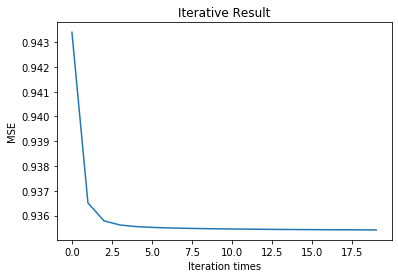

In [298]:
plt.plot(range(0, 20, 1), mse)
plt.title("Iterative Result")
plt.xlabel("Iteration times")
plt.ylabel("MSE")
plt.show()

In [295]:
userSorted = sorted(betaUsers.items(), key = lambda kv:(kv[1], kv[0]))
bookSorted = sorted(betaBooks.items(), key = lambda kv:(kv[1], kv[0]))
print("User with smallest values of β: ", userSorted[0])
print("User with largest values of β: ", userSorted[len(userSorted) - 1])
print("Book with smallest values of β: ", bookSorted[0])
print("Book with largest values of β: ", bookSorted[len(bookSorted) - 1])

User with smallest values of β:  ('u80513837', -3.5038539118995247)
User with largest values of β:  ('u81539151', 1.1912735158321108)
Book with smallest values of β:  ('b84091840', -1.3961499151210783)
Book with largest values of β:  ('b19925500', 0.9535291081561318)


In [305]:
predictions = open("prediction_Read_myRealSolution_3.txt", 'w')
for l in open("pairs_Rating.txt"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split('-')
    pred_mySolution = prediction(u, b)
    predictions.write(u + '-' + b + ",%f\n" % pred_mySolution)
    
predictions.close()